In [53]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import PIL
import numpy as np
import tensorflow as tf
import os
import pandas as pd
import deepsmiles
from tensorflow.keras.preprocessing.text import one_hot
from keras.utils import to_categorical

RDKit WARNING: [10:13:46] Enabling RDKit 2019.09.1 jupyter extensions


In [475]:
##smiles generation with LSTMs 
# !pip install --upgrade deepsmiles

  Using cached https://files.pythonhosted.org/packages/c4/aa/c043624e7cdac49811725dfc139423b5092bbf7cccb5a346d63ea0f364c1/deepsmiles-1.0.1-py2.py3-none-any.whl


In [1]:

converter = deepsmiles.Converter(rings=True, branches=True)

In [2]:


SMILES =pd.read_csv('rand_smiles.csv')

def transform(SMILES):
    SMILES_num=[]
    smile1=[]
    for index, smile in SMILES.iterrows():
    
      SMILES_num.append([ord(c) for c in converter.encode(smile['smiles'])])
    return(SMILES_num)

def training_set(smiles):
    Train_X=[]
    Train_Y=[]
    for smile in smiles:
            for i in range(len(smile)):
                    Train_X.append(smile[:i])
                    Train_Y.append(smile[i])
            Train_X.append(smile)
            Train_Y.append(ord('!'))
    return(Train_X, Train_Y)

        
        
        
    
    

In [4]:
numeric_smiles=transform(SMILES)
X, y=training_set(numeric_smiles)
encoded_y=to_categorical(y)
padded_X = tf.keras.preprocessing.sequence.pad_sequences(X,
                                                              padding='pre',
                                                             maxlen=(len(max(X, key=len))))
padded_X=padded_X.reshape((padded_X.shape[0],padded_X.shape[1], 1))
padded_X=padded_X/np.max(padded_X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(padded_X,encoded_y,test_size=0.05)

In [97]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Masking(mask_value=0, input_shape=(len(max(X, key=len)),1)))
# model.add(tf.keras.layers.Embedding(input_dim=(94), output_dim=16, input_length=1,mask_zero=True))
model.add(tf.keras.layers.LSTM(256, return_sequences=True))
model.add(tf.keras.layers.LSTM(256,return_sequences=True))
model.add(tf.keras.layers.LSTM(256,return_sequences=False))
model.add(tf.keras.layers.Dense(100, activation='relu'))
# model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(94,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0001),metrics=['accuracy'])

In [99]:

history = model.fit(X_train, y_train, epochs=2000, batch_size=256,  validation_data=(X_test,y_test),
                   verbose=1, shuffle=True)

Train on 1933153 samples, validate on 101745 samples
Epoch 1/2000
1933153/1933153 [==============================] - 1555s 804us/sample - loss: 0.8074 - accuracy: 0.6917 - val_loss: 0.8405 - val_accuracy: 0.6808
Epoch 2/2000
1933153/1933153 [==============================] - 1458s 754us/sample - loss: 0.8036 - accuracy: 0.6926 - val_loss: 0.8406 - val_accuracy: 0.6807
Epoch 3/2000
1933153/1933153 [==============================] - 1454s 752us/sample - loss: 0.8020 - accuracy: 0.6930 - val_loss: 0.8402 - val_accuracy: 0.6803
Epoch 4/2000
1933153/1933153 [==============================] - 1541s 797us/sample - loss: 0.8010 - accuracy: 0.6931 - val_loss: 0.8430 - val_accuracy: 0.6798
Epoch 5/2000
1933153/1933153 [==============================] - 1529s 791us/sample - loss: 0.8002 - accuracy: 0.6934 - val_loss: 0.8424 - val_accuracy: 0.6800
Epoch 6/2000
1933153/1933153 [==============================] - 1690s 874us/sample - loss: 0.7995 - accuracy: 0.6934 - val_loss: 0.8432 - val_accuracy: 

KeyboardInterrupt: 

In [98]:
##load my checkpoint
model.load_weights('lstm_smiles.hdf5')

In [363]:
init=np.zeros(41).reshape(1,41,1)
nums=[]
##the first character in the Smiles code, can be anything
seed='C'
count=0
for c in seed:
    nums.append(ord(c))
for j in reversed(range(len(nums))):
        init[0,-j,0]=nums[count]/93
        count+=1
model.reset_states()
for i in range(30):
    pred=model.predict(init)
    sample=np.random.choice(94, p=pred[0])
    ##break if reach end token
    if chr(sample)=='!':
        break
    nums.append(sample)
#     nums.append(np.argmax(pred[0]))
    count=0
    for j in reversed(range(len(nums))):
        init[0,-j,0]=nums[count]/93
        count+=1
    



In [364]:
mol=''.join([chr(c) for c in 
         nums])

In [365]:
mol=converter.decode(mol)

In [366]:
mol

'CCC1(O)CC2C13CC23'

In [367]:
##if invalid predict a new molecule
m = Chem.MolFromSmiles(mol)
AllChem.Compute2DCoords(m)

0

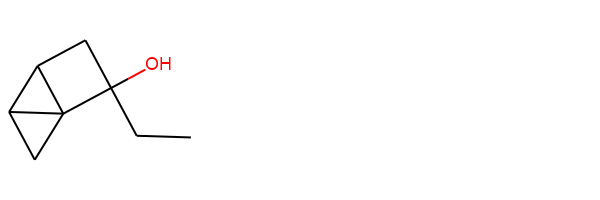

In [368]:
Draw.MolsToGridImage([m])

In [369]:
##check for mol in training set
SMILES[SMILES['smiles']==mol]

,smiles
